In [1]:
import os
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import glob

PATH_DATASET = "/kaggle/input/icecube-neutrinos-in-deep-ice"

newfigparams = {
                "figure.figsize": (10,4),
                "figure.dpi": 150,
                "axes.titlesize": 20,
                "axes.labelsize": 11,
                "ytick.labelsize": 11,
                "xtick.labelsize": 11,
                "legend.fontsize": 12,
                "legend.frameon": True,
                "lines.linewidth": 1,
                "axes.grid" : False
                }
plt.rcParams.update(newfigparams)
plt.style.use("dark_background")


import warnings
warnings.filterwarnings('ignore')



In [2]:
meta_train = pd.read_parquet(os.path.join(PATH_DATASET, "train_meta.parquet"))
print(f"length: {len(meta_train)}")
display(meta_train.head())
display(meta_train.info())

length: 131953924


,batch_id,event_id,first_pulse_index,last_pulse_index,azimuth,zenith
0,1,24,0,60,5.029555,2.087498
1,1,41,61,111,0.417742,1.549686
2,1,59,112,147,1.160466,2.401942
3,1,67,148,289,5.845952,0.759054
4,1,72,290,351,0.653719,0.939117


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131953924 entries, 0 to 131953923
Data columns (total 6 columns):
 #   Column             Dtype  
---  ------             -----  
 0   batch_id           int64  
 1   event_id           Int64  
 2   first_pulse_index  int64  
 3   last_pulse_index   int64  
 4   azimuth            float64
 5   zenith             float64
dtypes: Int64(1), float64(2), int64(3)
memory usage: 6.0 GB


None

In [3]:

meta_test = pd.read_parquet(os.path.join(PATH_DATASET, "test_meta.parquet"))
print(f"length: {len(meta_test)}")
meta_test.head()



length: 3


,batch_id,event_id,first_pulse_index,last_pulse_index
0,661,2092,0,298
1,661,7344,299,334
2,661,9482,335,377


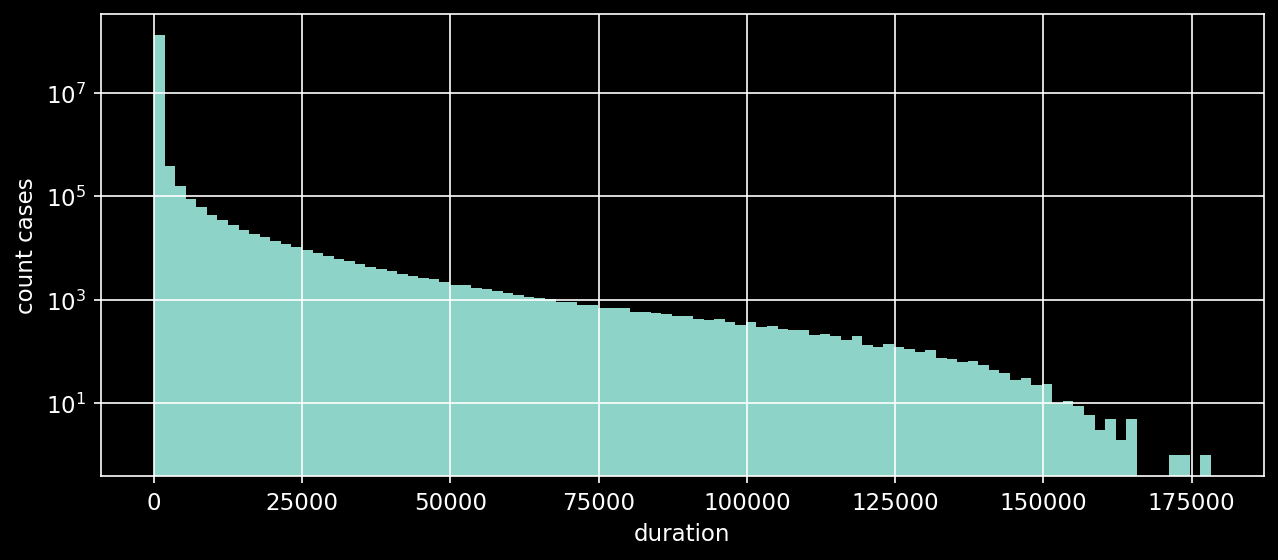

In [4]:
meta_train["delay_pulse_index"] = meta_train["last_pulse_index"] - meta_train["first_pulse_index"]
_ = plt.hist(meta_train["delay_pulse_index"], bins=100, log=True)
plt.ylabel('count cases'), plt.xlabel('duration')
plt.grid()

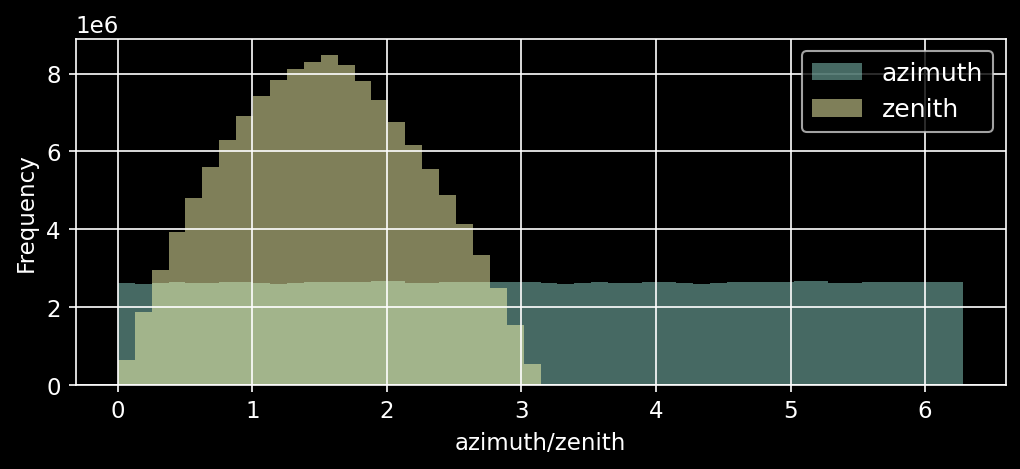

In [5]:
meta_train[["azimuth", "zenith"]].plot.hist(bins=50, alpha=0.5, figsize=(8, 3))
plt.xlabel('azimuth/zenith')
plt.grid()

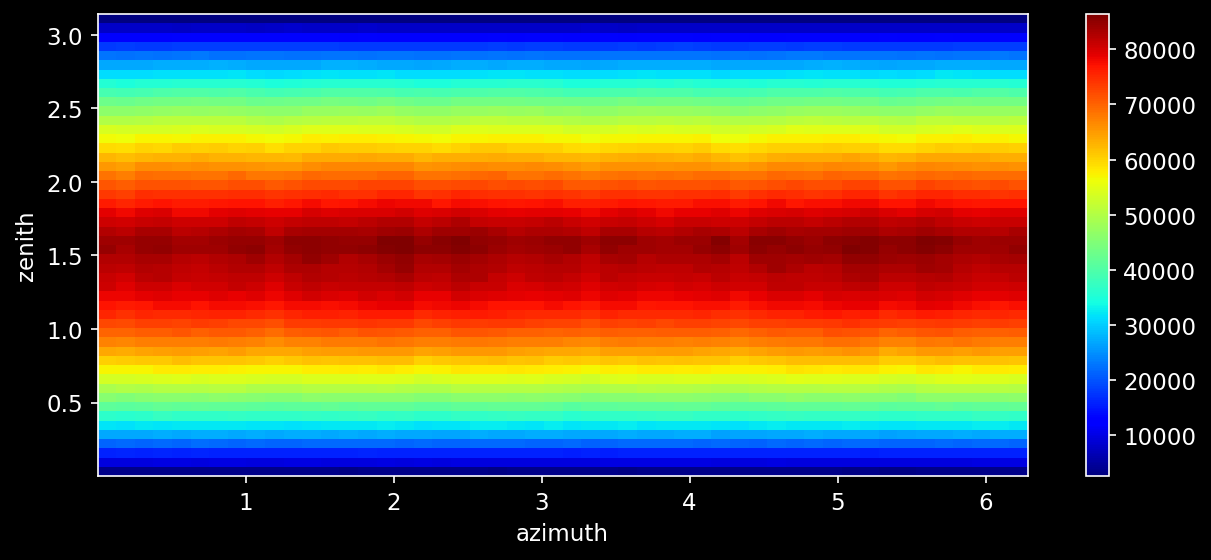

In [6]:
plt.hist2d(meta_train["azimuth"], meta_train["zenith"], bins=(50, 50), cmap=plt.cm.jet)
plt.xlabel('azimuth'), plt.ylabel('zenith')
plt.colorbar()

In [7]:
geometry = pd.read_csv(os.path.join(PATH_DATASET, "sensor_geometry.csv"))
print(f"length: {len(geometry)}")
geometry.head()

length: 5160


,sensor_id,x,y,z
0,0,-256.14,-521.08,496.03
1,1,-256.14,-521.08,479.01
2,2,-256.14,-521.08,461.99
3,3,-256.14,-521.08,444.97
4,4,-256.14,-521.08,427.95


In [8]:
import plotly.express as px

fig = px.scatter_3d(geometry, x='x', y='y', z='z', opacity=0.6, color="sensor_id")
fig.update_traces(marker=dict(size=2, color="#0097a7"))
fig.update_layout(height=600, width=600, scene=dict(bgcolor='black'), template="plotly_dark")
fig.show()


In [37]:
test = pd.read_parquet(os.path.join(PATH_DATASET, "test/batch_661.parquet"))
print(f"length: {len(test)}")
print(f"events: {len(test.index.unique())}")
test.head()


length: 378
events: 3


,sensor_id,time,charge,auxiliary
event_id,,,,
2092,4066,6170,1.275,True
2092,3512,6374,0.975,True
2092,897,6378,1.475,True
2092,2060,6590,0.925,True
2092,3072,6625,1.075,True


In [10]:
train = pd.read_parquet(os.path.join(PATH_DATASET, "train/batch_15.parquet"))
print(f"length: {len(train)}")
print(f"events: {len(train.index.unique())}")
train.head()

length: 32462509
events: 200000


,sensor_id,time,charge,auxiliary
event_id,,,,
45566128,541,6579,0.625,True
45566128,608,7373,0.825,True
45566128,3972,9208,0.625,True
45566128,619,9374,0.875,True
45566128,2790,9379,0.775,True


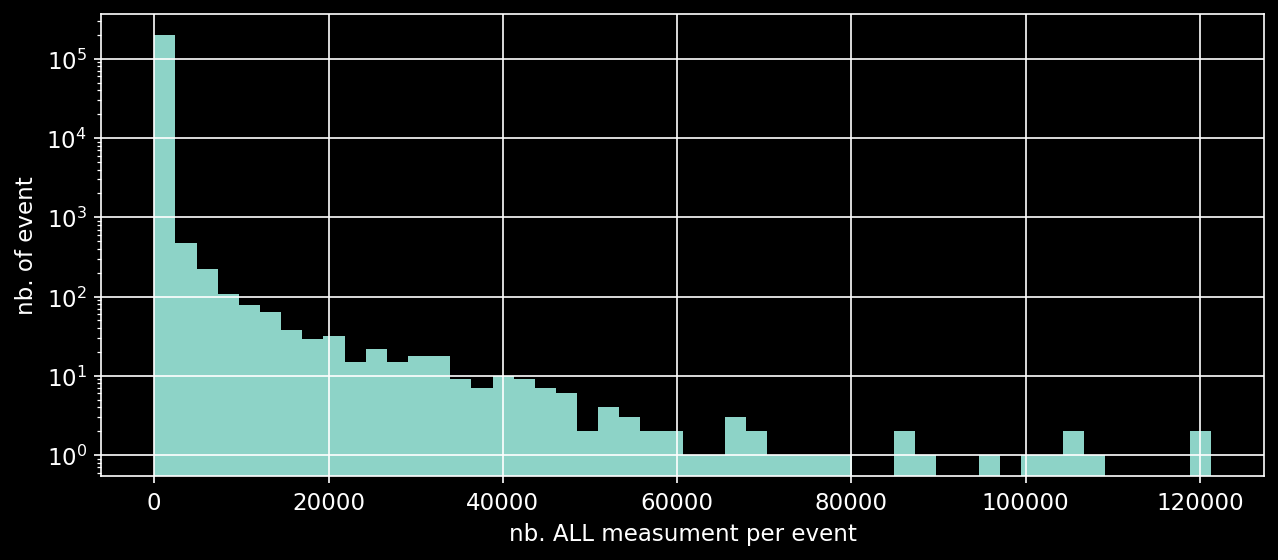

In [11]:
plt.figure(figsize=(10, 4))
_ = plt.hist(train.groupby(level=0).size(), bins=50, log=True)
plt.xlabel("nb. ALL measument per event"), plt.ylabel("nb. of event")
plt.grid()

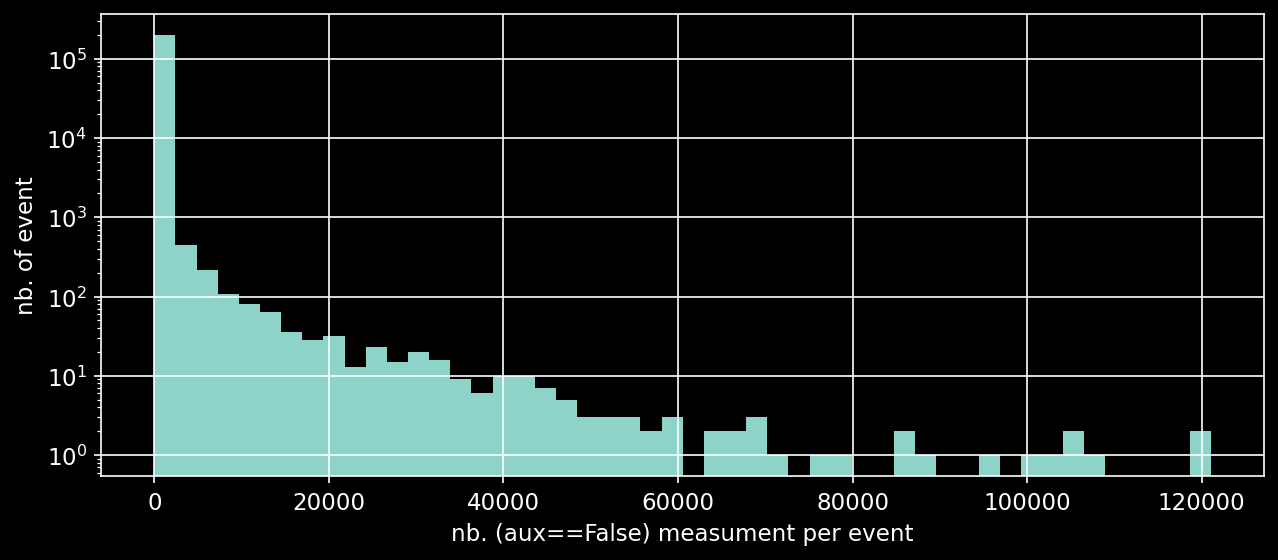

In [12]:
plt.figure(figsize=(10, 4))
_ = plt.hist(train[~train['auxiliary']].groupby(level=0).size(), bins=50, log=True)
plt.xlabel("nb. (aux==False) measument per event"), plt.ylabel("nb. of event")
plt.grid()

(None, <matplotlib.legend.Legend at 0x7f5aec19ad90>)

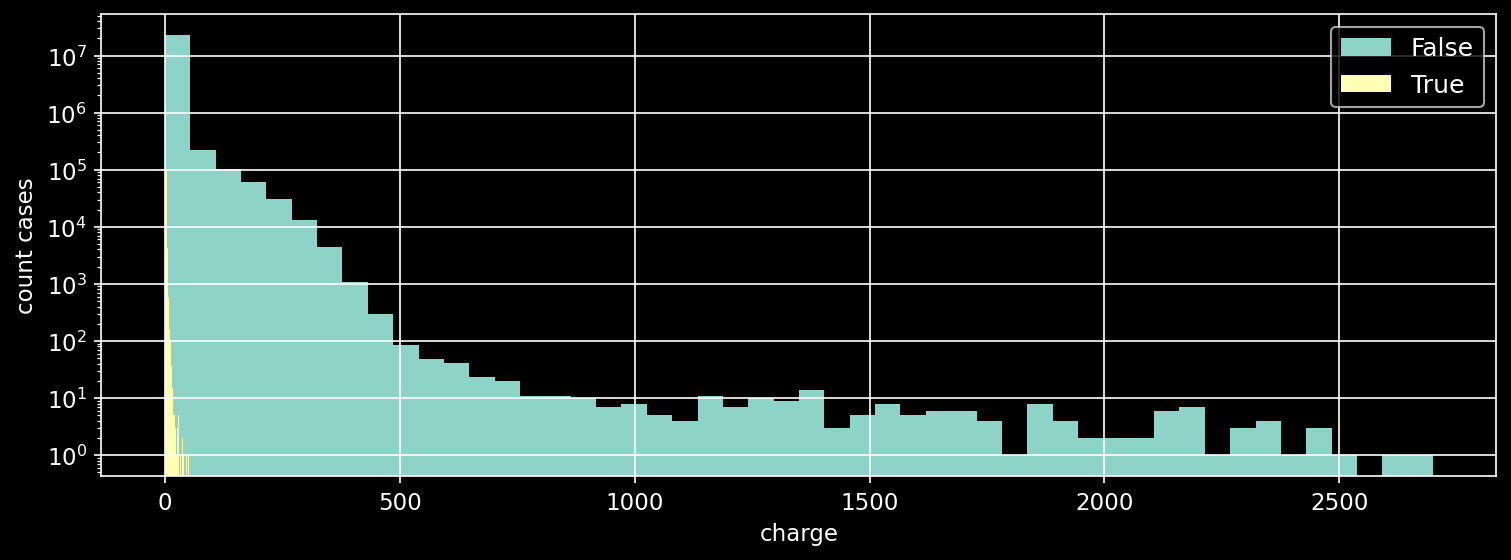

In [13]:
plt.figure(figsize=(12, 4))
_ = plt.hist(train[~train['auxiliary']]['charge'], bins=50, log=True, label="False")
_ = plt.hist(train[train['auxiliary']]['charge'], bins=50, log=True, label="True")
plt.ylabel('count cases'), plt.xlabel('charge')
plt.grid(), plt.legend()

In [14]:
meta_train[meta_train['event_id'].isin([46528394, 2135637939, 2084362251])]

,batch_id,event_id,first_pulse_index,last_pulse_index,azimuth,zenith,delay_pulse_index
2859071,15,46528394,9699041,9699108,4.870578,1.963840,67
128070215,641,2084362251,11716758,11716821,4.871734,1.957202,63
131224325,657,2135637939,4004627,4004681,4.862924,1.961885,54


In [15]:
import math

def charge_center(event):
    evt_sub = event[~event['auxiliary']][['x', 'y', 'z', 'charge']]
    evt_sub.loc[:, 'coef'] = evt_sub['charge'] / evt_sub['charge'].sum()
    # display(evt_sub)
    for c in ['x', 'y', 'z']:
        evt_sub.loc[:, c] *= evt_sub['coef']
    cx, cy, cz = evt_sub[['x', 'y', 'z']].sum().values
    return cx, cy, cz

def direction(meta):
    azimuth = meta["azimuth"]
    zenith = meta["zenith"]
    dx = math.sin(zenith) * math.cos(azimuth)
    dy = math.sin(zenith) * math.sin(azimuth)
    dz = math.cos(zenith)
    return dx, dy, dz

In [16]:
import plotly.graph_objects as go

def draw_subplot(fig, i, evt, sensors, cx, cy, cz, dx, dy, dz, scale=400):
    # sensors as background
    fig.add_trace(
        go.Scatter3d(
            x=sensors['x'], y=sensors['y'], z=sensors['z'], 
            mode='markers', marker=dict(size=1, color="#0097a7"), opacity=0.5
        ), row=(i+1), col=1)
    # sensors reading
    fig.add_trace(
        go.Scatter3d(
            x=evt['x'], y=evt['y'], z=evt['z'], opacity=0.8,
            mode='markers', marker=dict(
                size=evt['charge'] * 15,
                color=evt['time'],
                colorscale='sunsetdark',
            )
        ), row=(i+1), col=1)
    # direction from metad data
    fig.add_trace(
        go.Scatter3d(
            x=[cx - dx * scale, cx + dx * scale],
            y=[cy - dy * scale, cy + dy * scale],
            z=[cz - dz * scale, cz + dz * scale],
            opacity=0.8, mode='lines', line=dict(color='red', width=3)
        ), row=(i+1), col=1)

In [17]:
from plotly.subplots import make_subplots


def show_event(event_id=46528394, data=train, sensors=geometry, metadata=meta_train):
    meta = dict(metadata[metadata["event_id"]==event_id].iloc[0])
    display(meta)
    event = data[data.index == event_id]
    event = event.merge(sensors, on="sensor_id")
    event.loc[:, 'charge'] /= event['charge'].max()
    dx, dy, dz = direction(meta)
    cx, cy, cz = charge_center(event)
    #print(cx, cy, cz)
    
    auxiliaries = [False, True]
    fig = make_subplots(
        rows=2, specs=[[{'type': 'scene'}], [{'type': 'scene'}]],
        subplot_titles=[f"auxiliary={aux}" for aux in auxiliaries],
        vertical_spacing=0.05,
    )
    for i, aux in enumerate(auxiliaries):
        evt_ = event[event['auxiliary'] == aux]
        draw_subplot(fig, i, evt_, sensors, cx, cy, cz, dx, dy, dz)
    fig.update_layout(
        height=800, width=600, showlegend=False,
        title_text=f"Event #{event_id}"
        f" / azimuth={meta['azimuth']:0.3}; zenith={meta['zenith']:0.3}\n"
        f"-> x={dx:0.2}; y={dy:0.2}; z={dz:0.2}",
        scene=dict(bgcolor='black'), template="plotly_dark"
        
    )
    # fig = px.scatter_3d(event, x='x', y='y', z='z', size="charge", color="auxiliary",
    #     opacity=0.8, title=f"Event #{event_id}\n -> x={x_}; y={y_}; z={z_}")
    return fig

show_event().show()

{'batch_id': 15.0,
 'event_id': 46528394.0,
 'first_pulse_index': 9699041.0,
 'last_pulse_index': 9699108.0,
 'azimuth': 4.870578405540633,
 'zenith': 1.9638403862989229,
 'delay_pulse_index': 67.0}

In [18]:
from ipywidgets import interact, IntSlider

def interactive_show(events):
    interact(
        lambda i: show_event(events[i]).show(),
        i=IntSlider(min=0, max=len(events), step=1, value=len(events) // 2),
    )

events = train.index.unique().tolist()
interactive_show(events)

interactive(children=(IntSlider(value=100000, description='i', max=200000), Output()), _dom_classes=('widget-i…

# TensorFLow RNN - LSTM 


In [19]:
# Import Modules
import gc
import multiprocessing
import time
import pyarrow.parquet as pq
import tensorflow as tf
from tqdm import tqdm

In [20]:
# Directories and constants
home_dir = "/kaggle/input/icecube-neutrinos-in-deep-ice/"
test_format = home_dir + 'test/batch_{batch_id:d}.parquet'
model_home = "/kaggle/input/lstmicecubesdata/"

# Model(s)
model_names = ["4347_MAE_1-02076_bin24_pp96_n6_batch2048_epoch29.h5",
               "4347_MAE_1-02039_bin24_pp96_n6_batch2048_epoch25.h5", 
               "4346_MAE_1-02020_bin24_pp96_n6_batch2048_epoch27.h5"]
model_weights = np.array([0.30, 
                          0.30,
                          0.40])


In [21]:
# Load Models
models = []
for model_name in model_names:
    print(f'\n========== Model File: {model_name}')
    
    # Load Model
    model_path = model_home + model_name
    model = tf.keras.models.load_model(model_path)
    models.append(model)      
    
    
# Get Model Parameters
pulse_count = model.inputs[0].shape[1]
feature_count = model.inputs[0].shape[2]
output_bins = model.layers[-1].weights[0].shape[-1]
bin_num = int(np.sqrt(output_bins))

# Model Parameter Summary
print("\n==== Model Parameters")
print(f"Bin Numbers: {bin_num}")
print(f"Maximum Pulse Count: {pulse_count}")
print(f"Features Count: {feature_count}")


========== Model File: 4347_MAE_1-02076_bin24_pp96_n6_batch2048_epoch29.h5

========== Model File: 4347_MAE_1-02039_bin24_pp96_n6_batch2048_epoch25.h5

========== Model File: 4346_MAE_1-02020_bin24_pp96_n6_batch2048_epoch27.h5

==== Model Parameters
Bin Numbers: 24
Maximum Pulse Count: 96
Features Count: 6


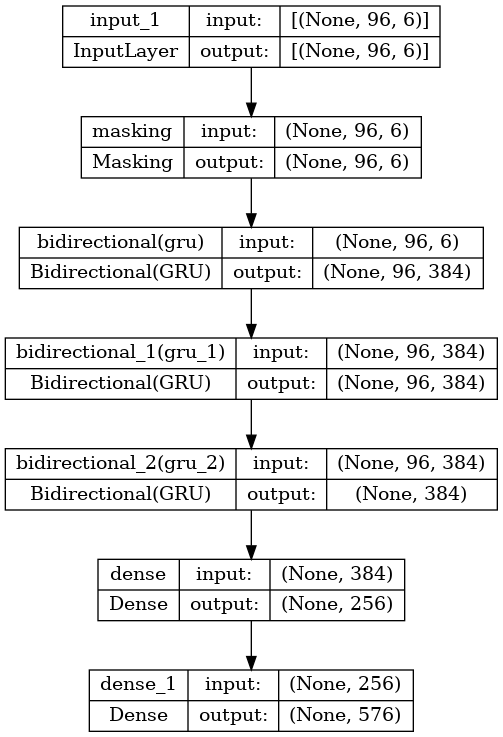

In [22]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

# Definir el modelo aquí (igual que en el código anterior)

# Crear un objeto TensorBoard para visualizar el modelo
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')

# Entrenar el modelo con el objeto TensorBoard como argumento de callback
# model.fit(x_train, y_train, epochs=10, callbacks=[tensorboard_callback])

# Generar una imagen del diagrama de flujo del modelo
plot_model(model, to_file='model.png', show_shapes=True)


In [23]:
# Load sensor_geometry
sensor_geometry_df = pd.read_csv(home_dir + "sensor_geometry.csv")

# Get Sensor Information
sensor_x = sensor_geometry_df.x
sensor_y = sensor_geometry_df.y
sensor_z = sensor_geometry_df.z

# Detector constants
c_const = 0.299792458  # speed of light [m/ns]

# Sensor Min / Max Coordinates
x_min = sensor_x.min()
x_max = sensor_x.max()
y_min = sensor_y.min()
y_max = sensor_y.max()
z_min = sensor_z.min()
z_max = sensor_z.max()

detector_length = np.sqrt((x_max - x_min)**2 + (y_max - y_min)**2 + (z_max - z_min)**2)
t_valid_length = detector_length / c_const

print(f"time valid length: {t_valid_length} ns")

time valid length: 6199.700247193777 ns


In [24]:
# Create Azimuth Edges
azimuth_edges = np.linspace(0, 2 * np.pi, bin_num + 1)
print(azimuth_edges)

# Create Zenith Edges
zenith_edges = []
zenith_edges.append(0)
for bin_idx in range(1, bin_num):
    zenith_edges.append(np.arccos(np.cos(zenith_edges[-1]) - 2 / (bin_num)))
zenith_edges.append(np.pi)
zenith_edges = np.array(zenith_edges)
print(zenith_edges)

[0.         0.26179939 0.52359878 0.78539816 1.04719755 1.30899694
 1.57079633 1.83259571 2.0943951  2.35619449 2.61799388 2.87979327
 3.14159265 3.40339204 3.66519143 3.92699082 4.1887902  4.45058959
 4.71238898 4.97418837 5.23598776 5.49778714 5.75958653 6.02138592
 6.28318531]
[0.         0.41113786 0.58568554 0.72273425 0.84106867 0.94796974
 1.04719755 1.1410209  1.23095942 1.31811607 1.40334825 1.48736624
 1.57079633 1.65422641 1.73824441 1.82347658 1.91063324 2.00057176
 2.0943951  2.19362291 2.30052398 2.41885841 2.55590711 2.73045479
 3.14159265]


In [25]:
angle_bin_zenith0 = np.tile(zenith_edges[:-1], bin_num)
angle_bin_zenith1 = np.tile(zenith_edges[1:], bin_num)
angle_bin_azimuth0 = np.repeat(azimuth_edges[:-1], bin_num)
angle_bin_azimuth1 = np.repeat(azimuth_edges[1:], bin_num)

angle_bin_area = (angle_bin_azimuth1 - angle_bin_azimuth0) * (np.cos(angle_bin_zenith0) - np.cos(angle_bin_zenith1))
angle_bin_vector_sum_x = (np.sin(angle_bin_azimuth1) - np.sin(angle_bin_azimuth0)) * ((angle_bin_zenith1 - angle_bin_zenith0) / 2 - (np.sin(2 * angle_bin_zenith1) - np.sin(2 * angle_bin_zenith0)) / 4)
angle_bin_vector_sum_y = (np.cos(angle_bin_azimuth0) - np.cos(angle_bin_azimuth1)) * ((angle_bin_zenith1 - angle_bin_zenith0) / 2 - (np.sin(2 * angle_bin_zenith1) - np.sin(2 * angle_bin_zenith0)) / 4)
angle_bin_vector_sum_z = (angle_bin_azimuth1 - angle_bin_azimuth0) * ((np.cos(2 * angle_bin_zenith0) - np.cos(2 * angle_bin_zenith1)) / 4)

angle_bin_vector_mean_x = angle_bin_vector_sum_x / angle_bin_area
angle_bin_vector_mean_y = angle_bin_vector_sum_y / angle_bin_area
angle_bin_vector_mean_z = angle_bin_vector_sum_z / angle_bin_area

angle_bin_vector = np.zeros((1, bin_num * bin_num, 3))
angle_bin_vector[:, :, 0] = angle_bin_vector_mean_x
angle_bin_vector[:, :, 1] = angle_bin_vector_mean_y
angle_bin_vector[:, :, 2] = angle_bin_vector_mean_z

angle_bin_vector_unit = angle_bin_vector[0].copy()
angle_bin_vector_unit /= np.sqrt((angle_bin_vector_unit**2).sum(axis=1).reshape((-1, 1)))


In [26]:
def pred_to_angle(pred, epsilon = 1e-8):
    # Convert prediction
    pred_vector = (pred.reshape((-1, bin_num**2, 1)) * angle_bin_vector).sum(axis = 1)
    
    # Normalize
    pred_vector_norm = np.sqrt((pred_vector**2).sum(axis = 1))
    mask = pred_vector_norm < epsilon
    pred_vector_norm[mask] = 1
    
    # Assign <1, 0, 0> to very small vectors (badly predicted)
    pred_vector /= pred_vector_norm.reshape((-1, 1))
    pred_vector[mask] = np.array([1., 0., 0.])
    
    # Convert to angle
    azimuth = np.arctan2(pred_vector[:, 1], pred_vector[:, 0])
    azimuth[azimuth < 0] += 2 * np.pi
    zenith = np.arccos(pred_vector[:, 2])
    
    # Mask bad norm predictions as 0, 0
    azimuth[mask] = 0.
    zenith[mask] = 0.
    
    return azimuth, zenith


In [27]:
def weighted_vector_ensemble(angles, weight):
    # Convert angle to vector
    vec_models = list()
    for angle in angles:
        az, zen = angle
        sa = np.sin(az)
        ca = np.cos(az)
        sz = np.sin(zen)
        cz = np.cos(zen)
        vec = np.stack([sz * ca, sz * sa, cz], axis=1)
        vec_models.append(vec)
    vec_models = np.array(vec_models)

    # Weighted-mean
    vec_mean = (weight.reshape((-1, 1, 1)) * vec_models).sum(axis=0) / weight.sum()
    vec_mean /= np.sqrt((vec_mean**2).sum(axis=1)).reshape((-1, 1))

    # Convert vector to angle
    zenith = np.arccos(vec_mean[:, 2])
    azimuth = np.arctan2(vec_mean[:, 1], vec_mean[:, 0])
    azimuth[azimuth < 0] += 2 * np.pi
    
    return azimuth, zenith

In [28]:
# Placeholder
open_batch_dict = dict()

# Read single event from batch_meta_df
def read_event(event_idx, batch_meta_df, pulse_count):
    # Read metadata
    batch_id, first_pulse_index, last_pulse_index = batch_meta_df.iloc[event_idx][["batch_id", "first_pulse_index", "last_pulse_index"]].astype("int")

    # close past batch df
    if batch_id - 1 in open_batch_dict.keys():
        del open_batch_dict[batch_id - 1]

    # open current batch df
    if batch_id not in open_batch_dict.keys():
        open_batch_dict.update({batch_id: pd.read_parquet(test_format.format(batch_id=batch_id))})
    
    batch_df = open_batch_dict[batch_id]
    
    # Read event
    event_feature = batch_df[first_pulse_index:last_pulse_index + 1]
    sensor_id = event_feature.sensor_id
    
    # Merge features into single structured array
    dtype = [("time", "float16"),
             ("charge", "float16"),
             ("auxiliary", "float16"),
             ("x", "float16"),
             ("y", "float16"),
             ("z", "float16"),
             ("rank", "short")]    
    
    # Create event_x
    event_x = np.zeros(last_pulse_index - first_pulse_index + 1, dtype)
    event_x["time"] = event_feature.time.values - event_feature.time.min()
    event_x["charge"] = event_feature.charge.values
    event_x["auxiliary"] = event_feature.auxiliary.values
    event_x["x"] = sensor_geometry_df.x[sensor_id].values
    event_x["y"] = sensor_geometry_df.y[sensor_id].values
    event_x["z"] = sensor_geometry_df.z[sensor_id].values

    # For long event, pick-up
    if len(event_x) > pulse_count:
        # Find valid time window
        t_peak = event_x["time"][event_x["charge"].argmax()]
        t_valid_min = t_peak - t_valid_length
        t_valid_max = t_peak + t_valid_length
        t_valid = (event_x["time"] > t_valid_min) * (event_x["time"] < t_valid_max)

        # Rank
        event_x["rank"] = 2 * (1 - event_x["auxiliary"]) + (t_valid)

        # Sort by Rank and Charge (important goes to backward)
        event_x = np.sort(event_x, order = ["rank", "charge"])

        # pick-up from backward
        event_x = event_x[-pulse_count:]

        # Sort events by time 
        event_x = np.sort(event_x, order = "time")

    return event_idx, len(event_x), event_x


In [29]:
# Read Test Meta data
test_meta_df = pq.read_table(home_dir + 'test_meta.parquet').to_pandas()
batch_counts = test_meta_df.batch_id.value_counts().sort_index()

batch_max_index = batch_counts.cumsum()
batch_max_index[test_meta_df.batch_id.min() - 1] = 0
batch_max_index = batch_max_index.sort_index()

# Support Function
def test_meta_df_spliter(batch_id):
    return test_meta_df.loc[batch_max_index[batch_id - 1]:batch_max_index[batch_id] - 1]

# Modelo

Nota: Este modelo fue entrenado en otro Notebook por fines de Complejidad Computacional, pero he aqui la arquitectura que se uso:

In [ ]:
# Training
validation_files_amount = 1
data_new_load_interval = 6      # Local Training: None
train_files_delta = 15          # Local Training: None
epochs = 75                     # Local Training: 30
batch_size = 8192               # Local Training: 2048
learning_rate = 0.0022          # Local Training: 0.0005
verbose = 0

# Training Batches
train_batch_id_min = 100
train_batch_id_max = 190
train_batch_ids = [*range(train_batch_id_min, train_batch_id_max+1)]
np.random.shuffle(train_batch_ids)
print(train_batch_ids)

# Model Parameters
pulse_count = 96
feature_count = 6
lstm_units = 192
bin_num = 24

# Data
base_dir = "/kaggle/input/lstmicecubesdata/"
file_format = base_dir + 'pp_mpc96_n7_batch_{batch_id:d}.npz'

def create_model():
    with strategy.scope(): 
        inputs = tf.keras.layers.Input((pulse_count, feature_count))
        
        x = tf.keras.layers.Masking(mask_value = 0., input_shape = (pulse_count, feature_count))(inputs)
        x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(lstm_units, return_sequences = True))(x)
        x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(lstm_units, return_sequences = True))(x)
        x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(lstm_units))(x)        
        x = tf.keras.layers.Dense(256, activation = 'relu')(x)
        
        outputs = tf.keras.layers.Dense(bin_num**2, activation = 'softmax')(x)

        # Finalize Model
        model = tf.keras.models.Model(inputs = inputs, outputs = outputs)

        # Compile model
        model.compile(loss = 'sparse_categorical_crossentropy',
                      optimizer= tf.keras.optimizers.Adam(learning_rate = learning_rate),
                      metrics = ['accuracy'])
        
        # Show Model Summary
        model.summary()

        return model
    
    # Get Fixed Validation Dataset
val_x, val_y = prep_validation_data(validation_files_amount)

# Create Model
model = create_model()

# For training other than Kaggle environment...provided enough RAM...Load all data
if data_new_load_interval is None and train_files_delta is None:
    print('\nLoading All Train Data')
    start_batch = validation_files_amount
    end_batch = start_batch + (len(train_batch_ids) - validation_files_amount)
    trn_x, trn_y_anglecode = prep_training_data(start_batch, end_batch)

# Epoch Loop
for e in range(epochs):
    print(f'=========== EPOCH: {e}')
    
    # Load new random batch of training files .. delta wise .. on Kaggle or Colab with limited RAM.
    if data_new_load_interval is not None and train_files_delta is not None and e % data_new_load_interval == 0:
        print(f'\nLoading Train Data at epoch: {e}')
        trn_x, trn_y_anglecode = prep_training_data(validation_files_amount)
    
    # Number of batches
    batch_count = trn_x.shape[0] // batch_size

    # Random Shuffle each epoch
    indices = np.arange(trn_x.shape[0])
    np.random.shuffle(indices)
    trn_x = trn_x[indices]
    trn_y_anglecode = trn_y_anglecode[indices]
        
    # Placeholder
    losses = []
    accuracy = []
        
    # Batch Loop
    for batch_index in tqdm(range(batch_count), total = batch_count):
        b_train_x = trn_x[batch_index * batch_size: batch_index * batch_size + batch_size,:]
        b_train_y = trn_y_anglecode[batch_index * batch_size: batch_index * batch_size + batch_size]
        
        metrics = model.train_on_batch(b_train_x, b_train_y)
        losses.append(metrics[0])
        accuracy.append(metrics[1])  
    
    # Save Model
    model.save(f'tpu_pp96_n{feature_count}_bin{bin_num}_batch{batch_size}_epoch{e}.h5')

    # Metrics
    valid_pred = model.predict(val_x, batch_size = batch_size, verbose = verbose)    
    valid_pred_azimuth, valid_pred_zenith = pred_to_angle(valid_pred)
    mae = angular_dist_score(val_y[:, 0], val_y[:, 1], valid_pred_azimuth, valid_pred_zenith)    
    print(f'Total Train Loss: {np.mean(losses):.4f}   Accuracy: {np.mean(accuracy):.4f}  MAE: {mae:.5f}')  
        
    # Memory Cleanup
    gc.collect()

In [30]:
# Get Batch IDs
test_batch_ids = test_meta_df.batch_id.unique()

# Submission Placeholders
test_event_id = []
test_azimuth = []
test_zenith = []

# Batch Loop
for batch_id in test_batch_ids:
    # Batch Meta DF
    batch_meta_df = test_meta_df_spliter(batch_id)

    # Set Pulses
    test_x = np.zeros((len(batch_meta_df), pulse_count, feature_count), dtype = "float16")    
    test_x[:, :, 2] = -1    

    # Read Event Data
    def read_event_local(event_idx):
        return read_event(event_idx, batch_meta_df, pulse_count)
    
    # Multiprocess Events
    iterator = range(len(batch_meta_df))
    with multiprocessing.Pool() as pool:
        for event_idx, pulsecount, event_x in pool.map(read_event_local, iterator):
            # Features
            test_x[event_idx, :pulsecount, 0] = event_x["time"]
            test_x[event_idx, :pulsecount, 1] = event_x["charge"]
            test_x[event_idx, :pulsecount, 2] = event_x["auxiliary"]
            test_x[event_idx, :pulsecount, 3] = event_x["x"]
            test_x[event_idx, :pulsecount, 4] = event_x["y"]
            test_x[event_idx, :pulsecount, 5] = event_x["z"]
    
    del batch_meta_df
    
    # Normalize
    test_x[:, :, 0] /= 1000  # time
    test_x[:, :, 1] /= 300  # charge
    test_x[:, :, 3:] /= 600  # space
        
    # Predict
    pred_angles = []
    for model in models:
        pred_model = model.predict(test_x, verbose=0)
        az_model, zen_model = pred_to_angle(pred_model)
        pred_angles.append((az_model, zen_model))
    
    # Get Predicted Azimuth and Zenith
    pred_azimuth, pred_zenith = weighted_vector_ensemble(pred_angles, model_weights)
    
    # Get Event IDs
    event_ids = test_meta_df.event_id[test_meta_df.batch_id == batch_id].values
    
    # Finalize 
    for event_id, azimuth, zenith in zip(event_ids, pred_azimuth, pred_zenith):
        if np.isfinite(azimuth) and np.isfinite(zenith):
            test_event_id.append(int(event_id))
            test_azimuth.append(azimuth)
            test_zenith.append(zenith)
        else:
            test_event_id.append(int(event_id))
            test_azimuth.append(0.)
            test_zenith.append(0.)

In [31]:
# Create and Save Submission.csv
submission_df = pd.DataFrame({"event_id": test_event_id,
                              "azimuth": test_azimuth,
                              "zenith": test_zenith})
submission_df = submission_df.sort_values(by = ['event_id'])
submission_df.to_csv("submission.csv", index = False)

In [32]:
submission_df.head()

,event_id,azimuth,zenith
0,2092,1.940449,1.543638
1,7344,3.408369,2.526495
2,9482,4.583631,1.533985
